<a href="https://colab.research.google.com/github/zuulaika/Projet-python/blob/main/Taux_ch%C3%B4mage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taux de chômage en France 2019 vs 2024

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

In [3]:
!pip install pandas fiona shapely pyproj rtree geopandas

In [2]:
import pandas as pd
import geopandas as gpd

On récupère en premier lieu les limites des départements

In [13]:
!pip install cartiflette
from cartiflette import carti_download

departements = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 2.3 MB/s eta 0:00:00


Reprojeter les données en Lambert 93 (EPSG: 2154) (Le Lambert 93 a été conçu pour être le moins déformant possible sur la France métropolitaine).

Carte avec la nouvelle projection

In [4]:
departements_lambert93 = departements.to_crs(epsg=2154)
print(f"CRS of 'departements_lambert93': {departements_lambert93.crs}")

CRS of 'departements_lambert93': EPSG:2154


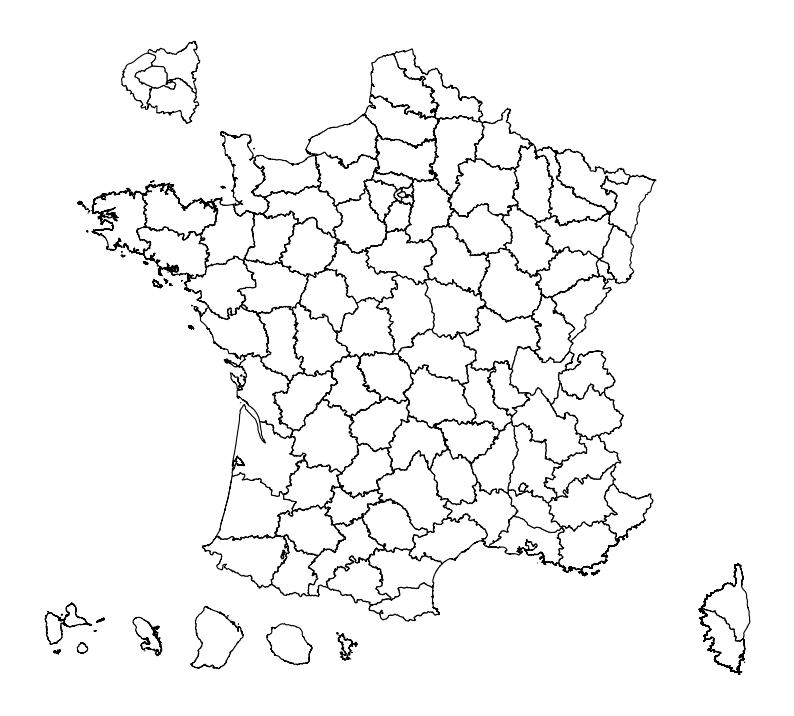

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
departements_lambert93.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)
ax.set_axis_off()
plt.show()

In [34]:
# URL directe du fichier
url = "https://www.data.gouv.fr/api/1/datasets/r/500d1954-9849-479b-9aac-85435c6d422f"
# Lecture avec encodage adapté
df5 = pd.read_excel(url, engine='openpyxl', header = 5, usecols=[0,1,7,10,12],
 nrows=101, sheet_name="Moyenne annuelle").dropna()
# Vérification
df5

,Département,Unnamed: 1,2019,2022,2024
0,01,Ain,6.050,5.450,5.600
1,02,Aisne,11.800,10.425,10.500
2,03,Allier,9.050,7.675,7.925
3,04,Alpes-de-Haute-Provence,10.075,8.225,7.925
4,05,Hautes-Alpes,7.925,6.875,6.225
...,...,...,...,...,...
96,M,France métropolitaine,8.175,7.075,7.175
97,971,Guadeloupe,20.125,18.600,16.750
98,972,Martinique,16.125,12.450,12.350
99,973,Guyane,17.125,13.125,16.950


## Preparer df5 Data pour Merging




Pour préparer le DataFrame df5 en vue de sa fusion, je vais d'abord convertir la colonne 'Département' en type chaîne de caractères pour assurer la cohérence des types de données, puis filtrer les lignes non-départementales, et enfin afficher les premières lignes et les informations du DataFrame nettoyé pour vérifier les modifications.



In [38]:
df5['Département'] = df5['Département'].astype(str)
df5 = df5[~df5['Département'].isin(['M', '971', '972', '973', '974'])]
print(df5.head())
print(df5.info())

  Département               Unnamed: 1    2019    2022    2024
0          01                      Ain   6.050   5.450   5.600
1          02                    Aisne  11.800  10.425  10.500
2          03                   Allier   9.050   7.675   7.925
3          04  Alpes-de-Haute-Provence  10.075   8.225   7.925
4          05             Hautes-Alpes   7.925   6.875   6.225
<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Département  96 non-null     object 
 1   Unnamed: 1   96 non-null     object 
 2   2019         96 non-null     float64
 3   2022         96 non-null     float64
 4   2024         96 non-null     float64
dtypes: float64(3), object(2)
memory usage: 4.5+ KB
None


/tmp/ipython-input-181490774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


La prochaine étape logique est de fusionner ce df5 DataFrame préparé avec le departements_lambert93 GeoDataFrame pour combiner les données géographiques avec les taux de chômage, ce qui est essentiel pour créer les choropleth maps.



In [36]:
merged_data_unemployment = departements_lambert93.merge(df5, left_on='INSEE_DEP', right_on='Département', how='left')

print("\nFirst few rows of merged_data_unemployment:")
print(merged_data_unemployment.head())
print("\nInfo of merged_data_unemployment:")
print(merged_data_unemployment.info())


First few rows of merged_data_unemployment:
  INSEE_DEP    PAYS LIBELLE_DEPARTEMENT  POPULATION  \
0        43  France         Haute-Loire      227570   
1        65  France     Hautes-Pyrénées      229567   
2        29  France           Finistère      915090   
3        22  France       Côtes-d'Armor      600582   
4        38  France               Isère     1271166   

                             SOURCE  \
0  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
1  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
2  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
3  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
4  IGN:EXPRESS-COG-CARTO-TERRITOIRE   

                                            geometry Département  \
0  POLYGON ((770266.6 6473465.6, 770255.9 6473419...          43   
1  MULTIPOLYGON (((449840.3 6280811.2, 449889.1 6...          65   
2  MULTIPOLYGON (((177277.8 6756845.8, 177266.5 6...          29   
3  MULTIPOLYGON (((245287.3 6878865.1, 245276.3 6...          22   
4  POLYGON ((863172.2 6525941.3, 862944.5 6525125

Les données ont été fusionnées avec succès. La prochaine étape consiste à visualiser les taux de chômage pour 2019 à l'aide d'une carte choroplèthe.



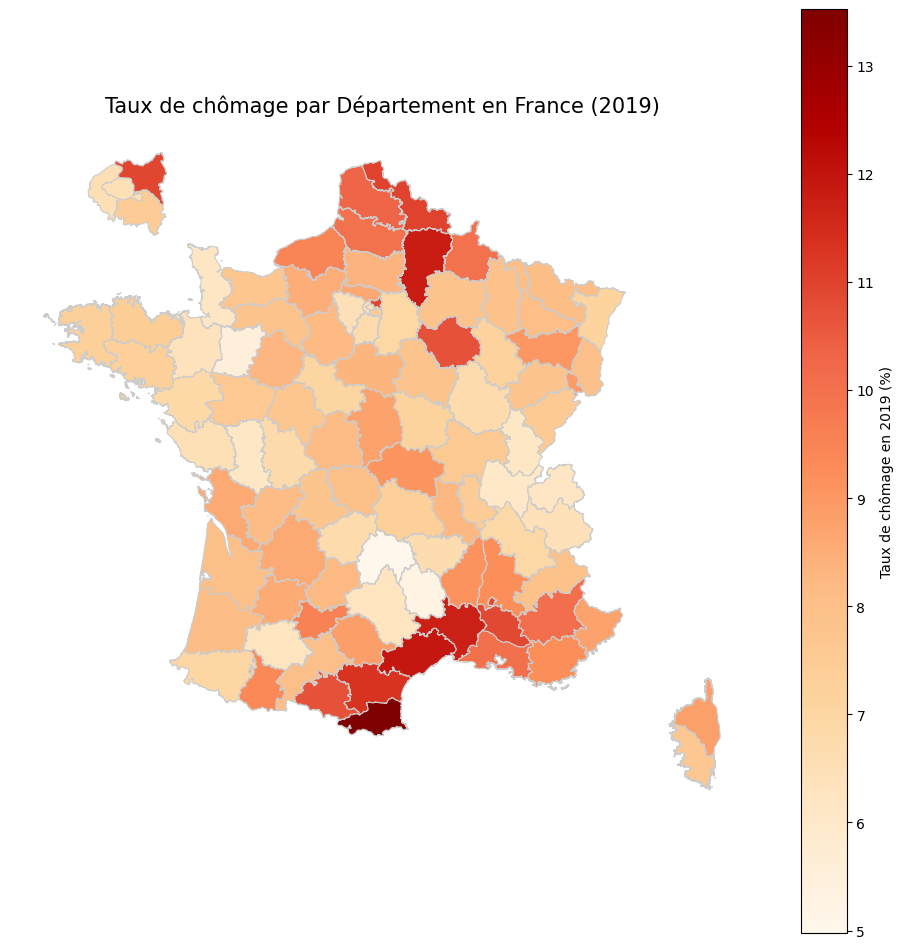

In [41]:

#Convertir tous les noms de colonnes dans merged_data_unemployment en type chaîne de caractères et supprimer tout espace blanc,
#garantissant ainsi un accès cohérent aux colonnes basé sur des chaînes de caractères pour le traçage."
merged_data_unemployment.columns = [str(col).strip() for col in merged_data_unemployment.columns]
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_data_unemployment.plot(column='2019', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                              legend_kwds={'label': "Taux de chômage en 2019 (%)", 'orientation': "vertical"})
ax.set_title("Taux de chômage par Département en France (2019)", fontsize=15)
ax.set_axis_off()
plt.show()

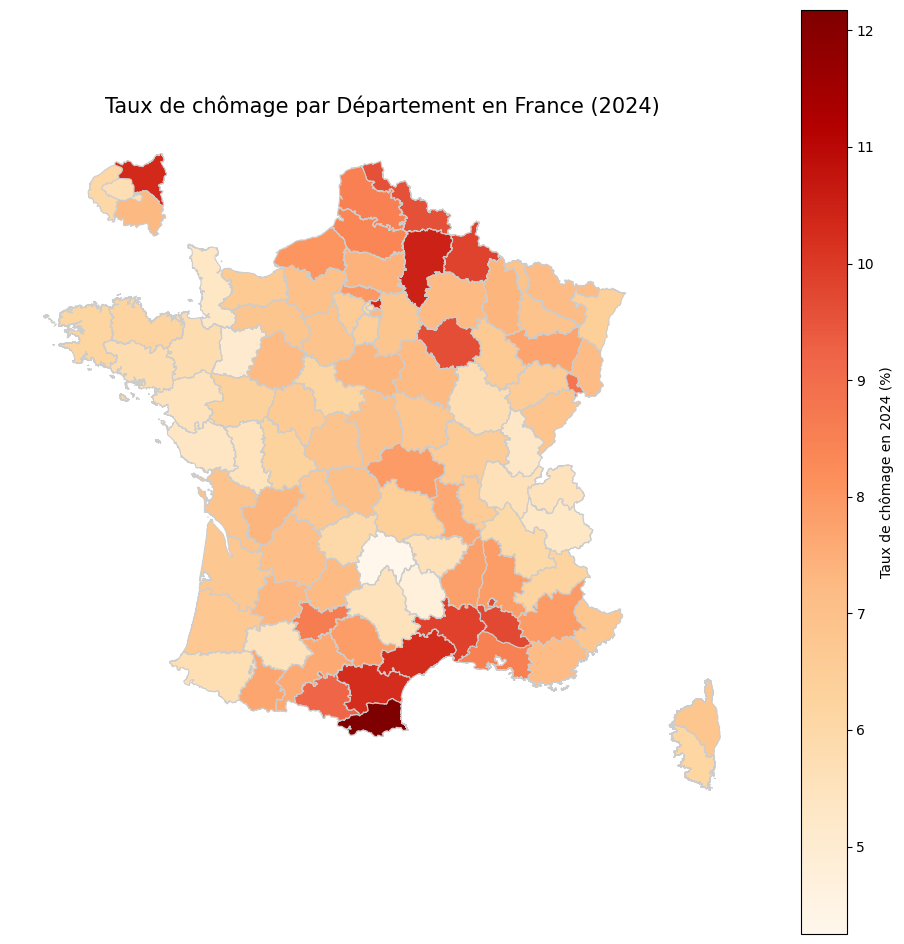

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_data_unemployment.plot(column='2024', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                              legend_kwds={'label': "Taux de chômage en 2024 (%)", 'orientation': "vertical"})
ax.set_title("Taux de chômage par Département en France (2024)", fontsize=15)
ax.set_axis_off()
plt.show()